<a href="https://colab.research.google.com/github/davidzillion/Predicting_Housing_Prices/blob/main/housing_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Housing Prices

We will only use numerical features

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np 

file_path_housing ='/content/drive/My Drive/Data/housing_prices_iteration3.csv'
housing = pd.read_csv(file_path_housing)
housing = housing.select_dtypes(include=['number']).copy()
housing.drop(columns=["Id"], inplace=True)

In [ ]:
housing.shape

(1460, 37)

## Data splitting

In [ ]:
from sklearn.model_selection import train_test_split

# define X and y (features and target)
X = housing.drop(columns="SalePrice")
y = housing["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)


## Data Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
X_train_ = minmax.fit_transform(X_train)

In [ ]:
X_train_scaled = pd.DataFrame(X_train_, columns=X.columns)

## Feature Selection


Some features, like "PoolArea", have very low variance. It is a same way of saying "very little information". We will kick out these features

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html

In [ ]:
X_train_scaled.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1168.000000,967.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1161.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1098.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,0.220865,0.166516,0.042371,0.561644,0.571169,0.713005,0.570434,0.063252,0.079973,0.032176,0.256160,0.171900,0.188922,0.164510,0.010081,0.220196,0.219178,0.030822,0.516838,0.184503,0.356914,0.349030,0.373216,0.200628,0.691003,0.435146,0.329258,0.128656,0.085851,0.072774,0.006180,0.033180,0.004079,0.003955,0.484823,0.450557
std,0.250193,0.084685,0.050519,0.154367,0.141451,0.218855,0.346709,0.112252,0.081457,0.109854,0.200742,0.072162,0.088421,0.209933,0.085908,0.098627,0.260002,0.123815,0.184370,0.250089,0.103918,0.074574,0.135589,0.219898,0.237334,0.186922,0.151302,0.168645,0.123294,0.189362,0.058036,0.123663,0.057391,0.035482,0.247466,0.333706
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.123288,0.028143,0.444444,0.500000,0.586957,0.266667,0.000000,0.000000,0.000000,0.098235,0.128273,0.122074,0.000000,0.000000,0.149209,0.000000,0.000000,0.333333,0.000000,0.250000,0.333333,0.250000,0.000000,0.519231,0.250000,0.220028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.363636,0.250000
50%,0.176471,0.164384,0.037064,0.555556,0.500000,0.721014,0.716667,0.000000,0.069897,0.000000,0.215281,0.160720,0.172441,0.000000,0.000000,0.209118,0.000000,0.000000,0.666667,0.000000,0.375000,0.333333,0.333333,0.333333,0.692308,0.500000,0.334274,0.000000,0.042065,0.000000,0.000000,0.000000,0.000000,0.000000,0.454545,0.500000
75%,0.294118,0.202055,0.046637,0.666667,0.625000,0.927536,0.900000,0.100625,0.127746,0.000000,0.364259,0.212848,0.242370,0.346731,0.000000,0.266767,0.500000,0.000000,0.666667,0.500000,0.375000,0.333333,0.416667,0.333333,0.920673,0.500000,0.406206,0.228261,0.124283,0.000000,0.000000,0.000000,0.000000,0.000000,0.636364,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# X_train_scaled.var()

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.05)
X_train_F = selector.fit_transform(X_train_scaled)

In [ ]:
# those are the indices of the columns kept
kept_columns = selector.get_support(indices=True)
kept_columns

array([ 0,  6, 16, 19, 24, 34, 35])

In [ ]:
# those are the column names
kept_columns_names = X_train_scaled.columns[kept_columns]
kept_columns_names

Index(['MSSubClass', 'YearRemodAdd', 'BsmtFullBath', 'HalfBath', 'GarageYrBlt',
       'MoSold', 'YrSold'],
      dtype='object')

In [ ]:
X_train_selected = pd.DataFrame(X_train_F, columns=kept_columns_names)
X_train_selected

,MSSubClass,YearRemodAdd,BsmtFullBath,HalfBath,GarageYrBlt,MoSold,YrSold
0,0.000000,0.283333,0.0,0.0,0.586538,0.545455,0.75
1,0.235294,0.850000,0.5,0.5,0.913462,0.363636,0.25
2,0.000000,0.966667,0.5,0.5,0.625000,0.272727,1.00
3,0.235294,0.716667,0.0,0.5,0.836538,0.454545,0.50
4,0.235294,0.416667,0.5,0.5,0.663462,0.090909,0.00
...,...,...,...,...,...,...,...
1163,0.176471,0.883333,0.0,0.0,0.423077,0.454545,0.00
1164,0.000000,0.866667,0.5,0.0,0.913462,0.454545,0.75
1165,0.176471,0.533333,0.5,0.0,0.326923,0.545455,0.50
1166,0.823529,0.916667,0.0,0.5,0.951923,0.272727,0.00


## Missing data

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html?highlight=simpleimputer#sklearn.impute.SimpleImputer

In [ ]:
X_train_selected.isna().sum()

MSSubClass       0
YearRemodAdd     0
BsmtFullBath     0
HalfBath         0
GarageYrBlt     70
MoSold           0
YrSold           0
dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")

In [ ]:
X_train_ready = imputer.fit_transform(X_train_selected)
X_train_ready = pd.DataFrame(X_train_ready, columns=kept_columns_names)
X_train_ready.isna().sum()

MSSubClass      0
YearRemodAdd    0
BsmtFullBath    0
HalfBath        0
GarageYrBlt     0
MoSold          0
YrSold          0
dtype: int64

## Modelling

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {
    "n_neighbors": range(1, 150),
    "weights": ['uniform', 'distance']
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


knn_search = RandomizedSearchCV(KNeighborsRegressor(),
                                   param_grid,
                                   scoring="neg_mean_absolute_error",
                                   n_iter=50,
                                   cv=5,
                                   n_jobs=4,
                                   random_state=123)

In [ ]:
knn_search.fit(X_train_ready, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                 metric='minkowski',
                                                 metric_params=None,
                                                 n_jobs=None, n_neighbors=5,
                                                 p=2, weights='uniform'),
                   iid='deprecated', n_iter=50, n_jobs=4,
                   param_distributions={'n_neighbors': range(1, 150),
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=123, refit=True,
                   return_train_score=False, scoring='neg_mean_absolute_error',
                   verbose=0)

In [ ]:
knn_search.best_params_

{'n_neighbors': 28, 'weights': 'uniform'}

In [ ]:
- knn_search.best_score_

42077.038546039075

## Testing

In [ ]:
X_test_scaled = minmax.transform(X_test)
X_test_selection = selector.transform(X_test_scaled)
X_test_ready = imputer.transform(X_test_selection)

In [ ]:
test_predictions = knn_search.predict(X_test_ready)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(test_predictions, y_test)

41370.802226027394

In [ ]:
test_results = {}

test_results["knn"] = mean_absolute_error(test_predictions, y_test)

# Predicting Housing Prices With Tensorflow

Following this example: https://www.tensorflow.org/tutorials/keras/regression

## Converting Dataframe to tensor

In [ ]:
X_train_ready.head()

,MSSubClass,YearRemodAdd,BsmtFullBath,HalfBath,GarageYrBlt,MoSold,YrSold
0,0.000000,0.283333,0.0,0.0,0.586538,0.545455,0.75
1,0.235294,0.850000,0.5,0.5,0.913462,0.363636,0.25
2,0.000000,0.966667,0.5,0.5,0.625000,0.272727,1.00
3,0.235294,0.716667,0.0,0.5,0.836538,0.454545,0.50
4,0.235294,0.416667,0.5,0.5,0.663462,0.090909,0.00


In [ ]:
X_train_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    1168 non-null   float64
 1   YearRemodAdd  1168 non-null   float64
 2   BsmtFullBath  1168 non-null   float64
 3   HalfBath      1168 non-null   float64
 4   GarageYrBlt   1168 non-null   float64
 5   MoSold        1168 non-null   float64
 6   YrSold        1168 non-null   float64
dtypes: float64(7)
memory usage: 64.0 KB


In [ ]:
import tensorflow as tf

In [ ]:
X_train_tensor = tf.convert_to_tensor(X_train_ready.values)
X_train_tensor

<tf.Tensor: shape=(1168, 7), dtype=float64, numpy=
array([[0.        , 0.28333333, 0.        , ..., 0.58653846, 0.54545455,
        0.75      ],
       [0.23529412, 0.85      , 0.5       , ..., 0.91346154, 0.36363636,
        0.25      ],
       [0.        , 0.96666667, 0.5       , ..., 0.625     , 0.27272727,
        1.        ],
       ...,
       [0.17647059, 0.53333333, 0.5       , ..., 0.32692308, 0.54545455,
        0.5       ],
       [0.82352941, 0.91666667, 0.        , ..., 0.95192308, 0.27272727,
        0.        ],
       [0.        , 0.41666667, 0.5       , ..., 0.66346154, 1.        ,
        0.        ]])>

In [ ]:
y_train_tensor = tf.convert_to_tensor(y_train)
y_train_tensor

<tf.Tensor: shape=(1168,), dtype=int64, numpy=array([100000, 226000, 149900, ..., 145000, 144152, 280000])>

## Linear Regression

https://www.tensorflow.org/tutorials/keras/regression

First we define the model as a single-layer neural network:

In [ ]:
lr_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

### Compile the model

Here we choose:

- The optimizer: which will define how we approach the right parameters for the model
- The loss function: whcih quantifies the error

In [ ]:
lr_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.5),
    loss='mean_absolute_error')

In [ ]:
# these predictions make no sense, because the parameters have not been tuned yet
# we get random predictions

lr_model.predict(X_train_tensor[:10])


array([[0.9310106 ],
       [0.5459139 ],
       [0.8125245 ],
       [0.36674076],
       [0.2307384 ],
       [0.88049316],
       [0.44826   ],
       [0.9273515 ],
       [0.6032017 ],
       [0.44337416]], dtype=float32)

In [ ]:
%%time 
# %%time gives perfomancetime =>
# CPU times: user 2min 39s, sys: 10.4 s, total: 2min 49s
# Wall time: 2min 44s
history = lr_model.fit(
    X_train_tensor, y_train_tensor,
    epochs=3000, # define number of iterations
    verbose=0, # suppress logging
    validation_split = 0.2)  # Calculate validation results on 20% of the training data

CPU times: user 2min 39s, sys: 10.4 s, total: 2min 49s
Wall time: 2min 44s


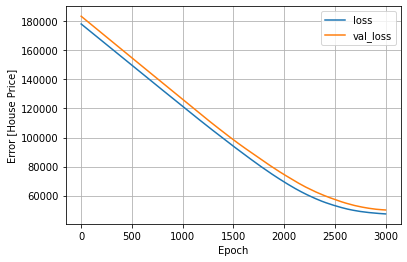

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [House Price]')
  plt.legend()
  plt.grid(True)

plot_loss(history)


### Performance on the test set

In [ ]:
from sklearn.metrics import mean_absolute_error

tf_lr_model_predictions = lr_model.predict(X_test_ready)
mean_absolute_error(y_test, tf_lr_model_predictions)

48950.90237050514

In [ ]:
test_results['linear_model'] = lr_model.evaluate(
    X_test_ready,
    np.array(y_test), verbose=0)

In [ ]:
test_results

{'knn': 41370.802226027394, 'linear_model': 48950.90234375}

## 2nd NN model

A "deep model"

In [ ]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=24, activation="relu"),
    tf.keras.layers.Dense(units=24, activation="relu"),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
deep_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
history = deep_model.fit(
    X_train_tensor, y_train_tensor,
    epochs=50,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

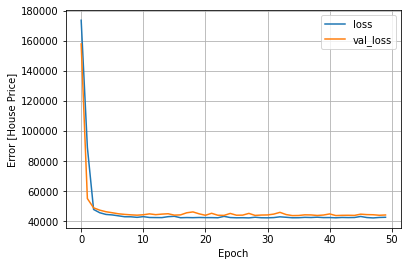

In [ ]:
plot_loss(history)


In [ ]:
test_results['deep_model'] = deep_model.evaluate(
    X_test_ready,
    np.array(y_test), verbose=0)

In [ ]:
test_results

{'deep_model': 41775.0078125,
 'knn': 41370.802226027394,
 'linear_model': 48950.90234375}

# 3rd iteration

A "deeper" model

In [ ]:
def model(X, y, learn_rate, n_epochs):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=1)
    ])

    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learn_rate),
        loss='mse',
        metrics=["mean_absolute_error"]
    )

    history = model.fit(
        X, y,
        epochs=n_epochs,
        verbose=0,
        validation_split = 0.2)
    return model, history

In [ ]:
deeper_model, history = model(X_train_tensor, y_train_tensor, 0.001, 200)

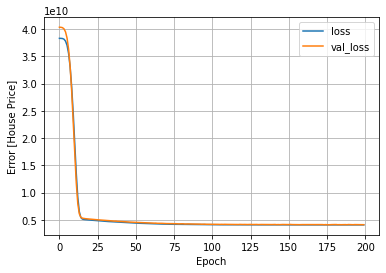

In [ ]:
plot_loss(history)

In [ ]:
deeper_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_results['deeper_model'] = deeper_model.evaluate(
    X_test_ready,
    np.array(y_test), verbose=0)[1]

test_results

{'deep_model': 41775.0078125,
 'deeper_model': 42474.375,
 'knn': 41370.802226027394,
 'linear_model': 48950.90234375}